<a href="https://colab.research.google.com/github/lasith54/Stock-Price-Predictor/blob/main/StockPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [710]:
# Load Google drive into Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [711]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

In [712]:
df = pd.read_csv('AMZN (1).csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-06-21,49.935001,50.136002,49.632500,50.111500,50.111500,58450000
1,2017-06-22,50.111500,50.348000,49.860001,50.064999,50.064999,45068000
2,2017-06-23,50.126999,50.230999,49.901001,50.187000,50.187000,57582000
3,2017-06-26,50.424999,50.490002,49.599998,49.699001,49.699001,67724000
4,2017-06-27,49.534500,49.939999,48.799999,48.839001,48.839001,75648000
...,...,...,...,...,...,...,...
1757,2024-06-14,183.080002,183.720001,182.229996,183.660004,183.660004,25456400
1758,2024-06-17,182.520004,185.000000,181.220001,184.059998,184.059998,35601900
1759,2024-06-18,183.740005,184.289993,181.429993,182.809998,182.809998,36659200
1760,2024-06-20,182.910004,186.509995,182.720001,186.100006,186.100006,43977300


In [713]:
df.shape

(1762, 7)

In [714]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [715]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [716]:
train_dates = pd.to_datetime(df['Date'])

In [717]:
feature_cols = ['Open', 'High', 'Low']
target_col = 'Close'

Text(0, 0.5, 'Price')

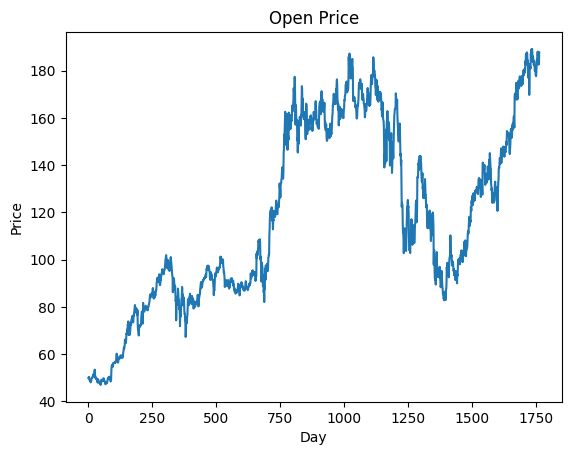

In [718]:
df_for_training = df[feature_cols + [target_col]].astype(float)

df_for_plot = df_for_training['Open'].tail(5000)
df_for_plot.plot.line()
plt.title('Open Price')
plt.xlabel('Day')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

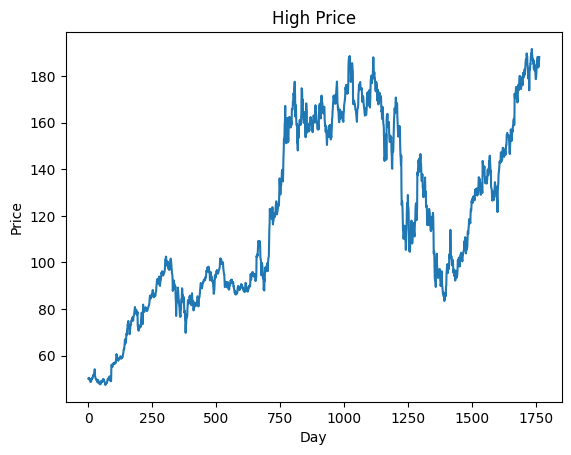

In [719]:
df_for_plot = df_for_training['High'].tail(5000)
df_for_plot.plot.line()
plt.title('High Price')
plt.xlabel('Day')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

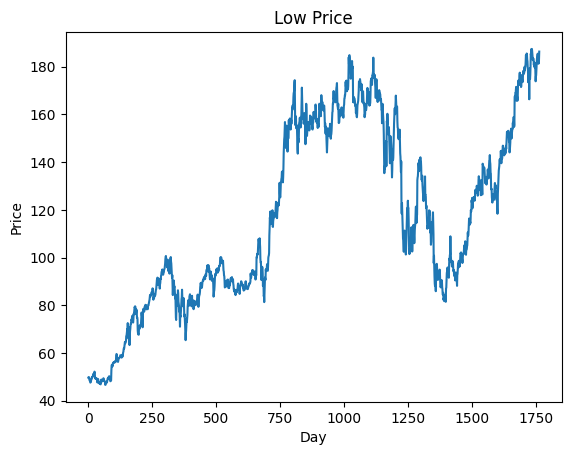

In [720]:
df_for_plot = df_for_training['Low'].tail(5000)
df_for_plot.plot.line()
plt.title('Low Price')
plt.xlabel('Day')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

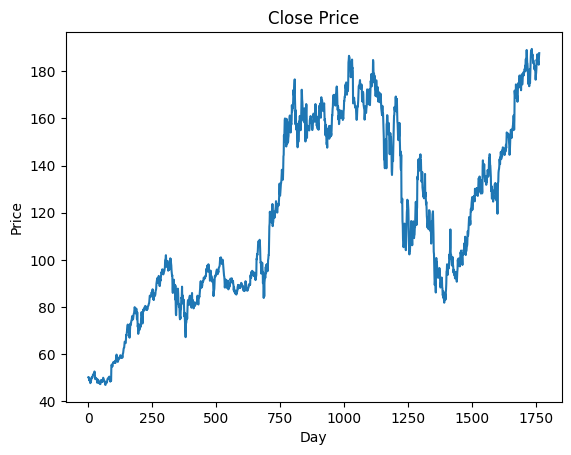

In [721]:
df_for_plot = df_for_training['Close'].tail(5000)
df_for_plot.plot.line()
plt.title('Close Price')
plt.xlabel('Day')
plt.ylabel('Price')

In [722]:
X = []
y = []

In [723]:
n_future = 1
n_past = 45

In [724]:
for i in range(n_past, len(df_for_training)-n_future+1):
  X.append(df_for_training.iloc[i-n_past:i, :-1])
  y.append(df_for_training.iloc[i + n_future - 1:i + n_future, -1])

X, y = np.array(X), np.array(y)

In [725]:
print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))

X shape == (1717, 45, 3).
y shape == (1717, 1).


In [726]:
X.shape

(1717, 45, 3)

In [727]:
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]

y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1373, 45, 3), (344, 45, 3), (1373, 1), (344, 1))

In [728]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
for i in range(X_train.shape[2]):
    X_train[:, :, i] = scaler_X.fit_transform(X_train[:, :, i])
    X_test[:, :, i] = scaler_X.transform(X_test[:, :, i])

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))


In [729]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1373, 45, 3]),
 torch.Size([344, 45, 3]),
 torch.Size([1373, 1]),
 torch.Size([344, 1]))

In [730]:
from torch.utils.data import Dataset, DataLoader

class StockPriceDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = StockPriceDataset(X_train, y_train)
test_dataset = StockPriceDataset(X_test, y_test)

In [731]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [732]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([100, 45, 3]) torch.Size([100, 1])


In [733]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(3, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [734]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 20 == 1:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss: {1:.8f}'.format(batch_index+1, avg_loss_across_batches))
      running_loss = 0.0

  print()

In [735]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val loss: {0:.4f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [736]:
learning_rate = 0.01
num_epochs = 150
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1
Batch 2, Loss: 0.01653320

Val loss: 0.2118
***************************************************

Epoch: 2
Batch 2, Loss: 0.00135011

Val loss: 0.1021
***************************************************

Epoch: 3
Batch 2, Loss: 0.00058146

Val loss: 0.0149
***************************************************

Epoch: 4
Batch 2, Loss: 0.00026340

Val loss: 0.0148
***************************************************

Epoch: 5
Batch 2, Loss: 0.00016971

Val loss: 0.0119
***************************************************

Epoch: 6
Batch 2, Loss: 0.00017216

Val loss: 0.0115
***************************************************

Epoch: 7
Batch 2, Loss: 0.00015519

Val loss: 0.0070
***************************************************

Epoch: 8
Batch 2, Loss: 0.00014964

Val loss: 0.0100
***************************************************

Epoch: 9
Batch 2, Loss: 0.00017758

Val loss: 0.0119
***************************************************

Epoch: 10
Batch 2, Loss: 0.00016093

Val loss:

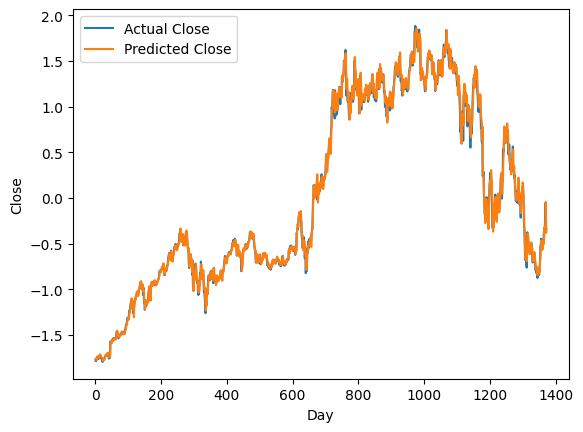

In [737]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [738]:
train_predictions = predicted.flatten()
train_predictions.shape

(1373,)

In [739]:
from copy import deepcopy as dc

train_predictions = predicted.flatten()

dummies = np.zeros((train_predictions.shape[0], 3))
dummies[:, 0] = train_predictions
train_predictions = scaler_y.inverse_transform(dummies)[:,0]

train_predictions = dc(train_predictions)
train_predictions

array([ 48.19073457,  47.76283887,  47.93039017, ..., 113.4418316 ,
       107.199626  , 100.73961871])

In [740]:
dummies = np.zeros((X_train.shape[0], 3))
dummies[:, 0] = y_train.flatten()
dummies = scaler_y.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 47.6225028 ,  47.26299787,  47.30099878, ..., 103.38999862,
       102.18000018, 102.1100006 ])

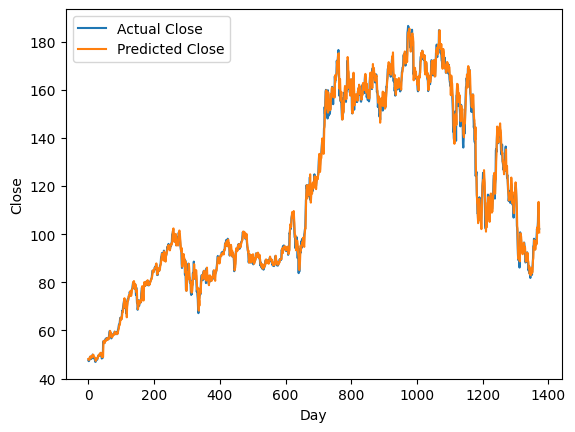

In [741]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [742]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
MAE = nn.L1Loss()
MA_error = MAE(torch.tensor(test_predictions), y_test_tensor)
print('Mean Absolute Error:', MA_error.item())

Mean Absolute Error: 0.8672090172767639


<ipython-input-742-53784f11dfd3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([344, 1])) that is different to the input size (torch.Size([344])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [743]:
dummies = np.zeros((X_test.shape[0], 3))
dummies[:, 0] = test_predictions
dummies = scaler_y.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 98.40197182,  98.17678831,  97.25229184,  97.20322147,
        99.30476802, 101.26076541, 101.99182945, 100.60902707,
        96.04194744,  93.41118415,  95.03015698,  93.51410722,
        92.80617927,  93.75421659,  94.75793926,  93.21670481,
        91.67310745,  94.40803293,  94.94757522,  93.89345374,
        92.72336236,  94.26225878,  91.33717729,  91.69723393,
        93.39292083,  95.8716986 ,  99.95718923,  98.79348559,
        96.03493109,  99.53431442, 100.17184256,  98.83757352,
        96.94283975,  97.58339445,  97.15119691, 100.56817937,
       103.58195225, 104.8786274 , 103.84791562, 103.98475822,
       101.24791642, 100.42008189, 100.49071686,  99.43802217,
        98.25704334, 102.10420301, 103.53276091, 103.72314079,
       103.00319482, 104.8905448 , 105.89303797, 107.93640454,
       107.26892576, 102.61628136, 105.00865263, 110.09908018,
       107.93971995, 102.75253492, 103.16558617, 105.97530091,
       105.55634298, 105.16091175, 105.7528353 , 106.66

In [744]:
dummies = np.zeros((X_test.shape[0], 3))
dummies[:, 0] = y_test.flatten()
dummies = scaler_y.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([100.0500027 ,  98.23999766,  97.61000141,  99.54000121,
        99.69999687, 101.160004  ,  98.15000158,  97.19999707,
        94.58000251,  95.79000095,  95.81999964,  93.4999999 ,
        93.76000287,  94.23000346,  92.16999765,  92.12999789,
        94.90000286,  93.74999954,  93.55000299,  93.9199974 ,
        92.24999943,  90.73000397,  92.43000062,  94.8799962 ,
        96.19999738, 100.0400005 ,  98.94999682,  97.70999855,
       100.61000049,  98.69999718,  98.70999938,  98.12999718,
        98.04000111,  97.23999796, 100.25000037, 102.00000012,
       103.29000148, 102.41000446, 103.94999755, 101.09999757,
       102.0599975 , 102.16999798,  99.91999782,  97.83000236,
       102.40000226, 102.5100016 , 102.73999797, 102.30000286,
       104.30000337, 103.80999838, 106.95999883, 106.20999878,
       102.57000012, 104.98000271, 109.81999987, 105.44999652,
       102.05000322, 103.62999719, 103.65000159, 103.99999951,
       105.66000375, 105.83000217, 106.62000312, 110.19

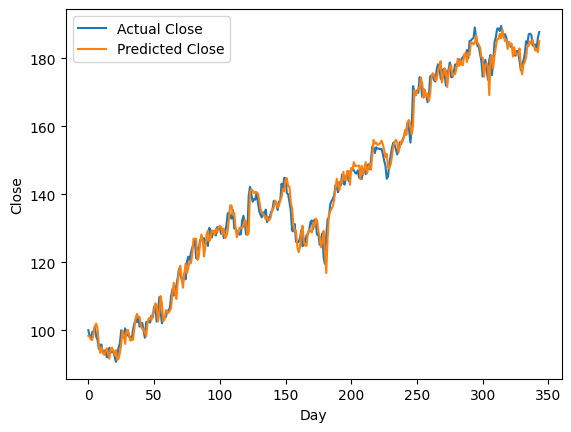

In [745]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [746]:
model_save_path = 'lstm_model.pth'
torch.save(model.state_dict(), model_save_path)